# CNN + LSTM
First try

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-13 12:14:42.927079
Python 3.10.0
sklearn 1.1.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=16
FILTERSIZE=10
RCELLS=16
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = True   # break after first fold
MINLEN=1000
MAXLEN=2000   

2022-12-13 12:14:48.271140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

/Users/jasonmiller/WVU/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [6]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-12-13 12:15:04.622895
Num RCI: 13000
[('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]


In [7]:
KMER_VALUES=dict()   # drop this after to save RAM
def seq_to_kmer_values(rna,K):
    VALS = {'A':0, 'C':1, 'G':2, 'T':3}
    length = len(rna)
    vec=[]
    for i in range(length-K+1):
        kmer = rna[i:i+K]
        if 'N' in kmer:
            value = 0
        elif kmer in KMER_VALUES.keys():
            value = KMER_VALUES[kmer]
        else:
            value = 0
            for j in range(K):
                value *= 4   
                nextnuc = kmer[j] 
                nucval = VALS[nextnuc]
                value += nucval
            value += 1   # NNN => 0, AAA => 1
            KMER_VALUES[kmer] = value
        vec.append(value)
    return vec
print(seq_to_kmer_values('AAAA',3))
print(seq_to_kmer_values('CATT',3))
print(seq_to_kmer_values('TTGA',3))
print(seq_to_kmer_values('TTTN',3))

[1, 1]
[20, 16]
[63, 57]
[64, 0]


In [8]:
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                hot_vec = seq_to_kmer_values(seq_txt,K)
                allseq.append(hot_vec)
print(datetime.now())
KMER_VALUES=dict()   # drop this after to save RAM

print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-12-13 12:15:04.743550
Load sequence
2022-12-13 12:15:19.041682
Num IDs: 13143
Num labels: 13143
Num counts: 13143


In [9]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [10]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    # To do: try with and without masking layer
    # To do: try the embedding layer with mask, instead of masking layer
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, K))
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, 1))
    # This layer automatically converts inputs to one-hot using alphabet size.
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    # rnn1_layer = LSTM(16, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
    # rnn1_layer = LSTM(RCELLS, return_sequences=False) # True)
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    # rnn1_layer = LSTM(16, return_sequences=True) 
    # rnn2_layer = LSTM(16, return_sequences=True)
    # Dense can handle sequence input. Is it the best thing to do?
    #dense1_layer = Dense(16,activation='sigmoid',dtype=dt)
    #dropout1_layer = Dropout(0.25)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(rnn1_layer)
    #rnn.add(rnn2_layer)
    #rnn.add(dense1_layer)
    #rnn.add(dropout1_layer)
    #rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [11]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-13 12:15:19.157121


2022-12-13 12:15:19.190685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 1988, 16)          656       
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,941
Trainable params: 5,941
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
def do_cross_validation(eps):
    cv_accuracy=[]
    cv_precision=[]
    cv_recall=[]
    cv_f1=[]
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        print('Training example')
        print(X_train[0])
        
        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        yhat_pred=model.predict(X_valid, verbose=0) 
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        THRESHOLD=0.5
        yhat_classes=np.where(yhat_pred > THRESHOLD, 1, 0)
        print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(y_valid, yhat_classes)*100.
        # precision tp / (tp + fp)
        precision = precision_score(y_valid, yhat_classes)*100.
        # recall: tp / (tp + fn)
        recall = recall_score(y_valid, yhat_classes)*100.
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_valid, yhat_classes)*100.
        print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
        print(datetime.now())
        cv_accuracy.append(accuracy)
        cv_precision.append(precision)
        cv_recall.append(recall)
        cv_f1.append(f1)
        
        if BREAK:
            break
        
    print()
    return cv_accuracy, cv_precision, cv_recall, cv_f1

print(datetime.now())

2022-12-13 12:15:20.606807


2022-12-13 12:15:20.634796
2022-12-13 12:15:20.635408
splitting
Fold 1
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10521, 1997) (10521, 1)
Valid sizes (2622, 1997) (2622, 1)
Train set ones/size 5687 / 10521
Valid set ones/size 1362 / 2622
BUILD MODEL
COMPILE
FIT
2022-12-13 12:15:24.006810
Epoch 1/5
329/329 [==============================] - 389s 1s/step - loss: 0.6825 - accuracy: 0.5597 - val_loss: 0.6902 - val_accuracy: 0.5542
Epoch 2/5
329/329 [==============================] - 348s 1s/step - loss: 0.6654 - accuracy: 0.6009 - val_loss: 0.6696 - val_accuracy: 0.5915
Epoch 3/5
329/329 [==============================] - 322s 979ms/step - loss: 0.6697 - accuracy: 0.5935 - val_loss: 0.6834 - val_accuracy: 0.5839
Epoch 4/5
329/329 [==============================] - 322s 979ms/step - loss: 0.6876 - accuracy: 0.5507 - val_loss: 0.6864 - val_accuracy: 0.5523
Epoch 5/5
329/329 [==============================] - 334s 1s/step - loss: 0.6798 - accuracy: 0.5665 - val_loss: 0.6871 -

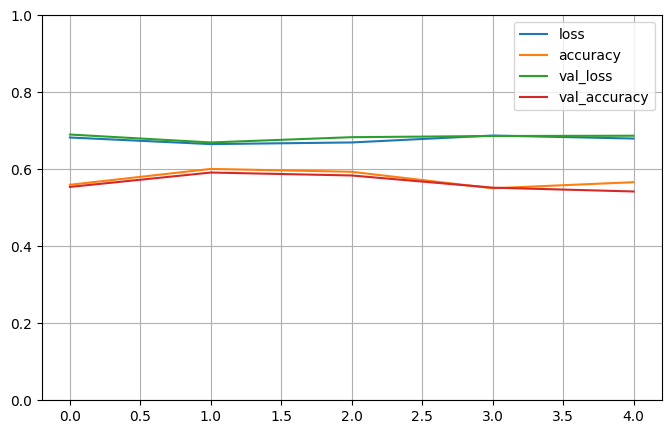

Compute valiation accuracy
2022-12-13 12:44:00.527839
Range of scores: 0.41162804 to 0.6605389
Predicted zeros and ones 910 1712
Accuracy: 54.23% Precision: 54.73% Recall: 68.80% F1: 60.96%
2022-12-13 12:44:14.461435

Cross validation 5 folds 5 epochs
 accuracy mean 54.23% +/- 0.00
 precision mean 54.73% +/- 0.00
 recall mean 68.80% +/- 0.00
 F1 mean 60.96% +/- 0.00
2022-12-13 12:44:14.466836


In [13]:
print(datetime.now())
cv_accuracy, cv_precision, cv_recall, cv_f1 = do_cross_validation(EPOCHS)   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())